# What is Persistence?

## Concept of Graph

A **Graph** in LangGraph is a computational workflow composed of:
- **Nodes**: Functions that perform operations (e.g., LLM calls, data processing)
- **Edges**: Connections that define execution flow between nodes
- **State**: Shared data structure that flows through the graph

```
     Node A
       ↓
    (Edge)
       ↓
     Node B  ← State flows through
       ↓
    (Edge)
       ↓
     Node C
```

## Concept of State

**State** is a shared data structure that:
- Stores variables/keys accessible to all nodes
- Gets passed along edges from node to node
- Can be read and modified by any node during execution
- Represents the current context of the graph execution

```python
# Example State
class GraphState(TypedDict):
    messages: list
    user_input: str
    result: str
```

Each node receives the current state, processes it, and returns updates.

## Concept of Persistence

**Persistence** enables saving and restoring graph state across executions. This provides:

1. **State Preservation**: Store the complete state after each node execution
2. **Conversation Memory**: Resume multi-turn conversations from where you left off
3. **Fault Tolerance**: Recover from crashes without losing progress
4. **Time Travel**: Access any previous checkpoint in execution history
5. **Debugging**: Inspect intermediate states for troubleshooting

```
Without Persistence:     With Persistence:
Run 1 → Lost ❌          Run 1 → Saved ✓
Run 2 → Start over       Run 2 → Continue from Run 1
```

## Checkpoint and Checkpointer

**Checkpoint**: A snapshot of the graph state at a specific point in execution
- Contains the complete state after a node finishes
- Includes metadata (timestamp, node name, thread_id)
- Allows rollback to any previous state

**Checkpointer**: The mechanism that manages checkpoint storage and retrieval

```python
# Common Checkpointers:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver

# In-memory (temporary)
memory = MemorySaver()

# Persistent database
checkpointer = SqliteSaver.from_conn_string("checkpoints.db")

# Attach to graph
graph = graph.compile(checkpointer=memory)
```

**How it works:**
```
Node Execution → Create Checkpoint → Store in Checkpointer
                       ↓
                 {state, metadata}
                       ↓
              Memory/SQLite/Postgres
```

**Thread ID**: Used to organize checkpoints by conversation/session
```python
config = {"configurable": {"thread_id": "conversation_1"}}
graph.invoke(input, config=config)  # Saves to thread_id
```

## Threads in Persistence

**Thread** is a unique identifier that isolates conversation sessions or execution contexts. Each thread maintains its own independent checkpoint history.

#### Single Thread Flow
```
Thread: "user_123"
┌─────────────────────────────────────┐
│  Checkpoint 1: Initial state        │
│  Checkpoint 2: After Node A         │
│  Checkpoint 3: After Node B         │
│  Checkpoint 4: Final state          │
└─────────────────────────────────────┘
```

#### Multiple Threads (Isolated Sessions)
```
Thread: "user_123"          Thread: "user_456"          Thread: "user_789"
┌──────────────────┐        ┌──────────────────┐        ┌──────────────────┐
│ Checkpoint 1     │        │ Checkpoint 1     │        │ Checkpoint 1     │
│ Checkpoint 2     │        │ Checkpoint 2     │        │ Checkpoint 2     │
│ Checkpoint 3     │        │ Checkpoint 3     │        │ Checkpoint 3     │
└──────────────────┘        └──────────────────┘        └──────────────────┘
     ↓                           ↓                           ↓
Independent history        Independent history        Independent history
```

#### Thread Usage Example
```python
# User 1's conversation
config_user1 = {"configurable": {"thread_id": "user_123"}}
graph.invoke({"input": "Hello"}, config=config_user1)
graph.invoke({"input": "How are you?"}, config=config_user1)  # Continues from previous

# User 2's conversation (completely separate)
config_user2 = {"configurable": {"thread_id": "user_456"}}
graph.invoke({"input": "Hi there"}, config=config_user2)  # Fresh start
```

#### Thread Lifecycle
```
┌─────────────┐
│ New Thread  │
│ thread_id=1 │
└──────┬──────┘
       │
       v
┌─────────────┐     ┌──────────────┐
│ Invoke #1   │────>│ Checkpoint 1 │
└──────┬──────┘     └──────────────┘
       │
       v
┌─────────────┐     ┌──────────────┐
│ Invoke #2   │────>│ Checkpoint 2 │  <- Loads Checkpoint 1 first
└──────┬──────┘     └──────────────┘
       │
       v
┌─────────────┐     ┌──────────────┐
│ Invoke #3   │────>│ Checkpoint 3 │  <- Loads Checkpoint 2 first
└─────────────┘     └──────────────┘
```

#### Key Benefits of Threads
1. **Isolation**: Each user/session has independent state
2. **Concurrency**: Multiple threads can run simultaneously
3. **Context Preservation**: Maintains conversation history per thread
4. **Scalability**: Handle thousands of concurrent conversations
5. **Debugging**: Trace specific user sessions independently

## Workflow Diagrams

### Without Persistence
```
Execution 1:                    Execution 2:
┌─────────┐                     ┌─────────┐
│ Start   │                     │ Start   │
└────┬────┘                     └────┬────┘
     │                               │
     v                               v
┌─────────┐                     ┌─────────┐
│ Node A  │                     │ Node A  │
│ State={}│                     │ State={}│  <- State resets!
└────┬────┘                     └────┬────┘
     │                               │
     v                               v
┌─────────┐                     ┌─────────┐
│ Node B  │                     │ Node B  │
└────┬────┘                     └────┬────┘
     │                               │
     v                               v
┌─────────┐                     ┌─────────┐
│  End    │                     │  End    │
└─────────┘                     └─────────┘
State Lost ❌                   No History ❌
```

### With Persistence (Checkpointing)
```
Execution 1:                    Execution 2:
┌─────────┐                     ┌─────────┐
│ Start   │                     │ Start   │
└────┬────┘                     └────┬────┘
     │                               │
     v                               v
┌─────────┐    ┌──────────┐    ┌─────────┐
│ Node A  │───>│Checkpoint│    │ Node A  │
│State={a}│    │  Save    │    │State={a}│  <- State restored!
└────┬────┘    └──────────┘    └────┬────┘
     │              │                │
     v              v                v
┌─────────┐    ┌──────────┐    ┌─────────┐
│ Node B  │───>│Checkpoint│    │ Node B  │
│State={b}│    │  Save    │    │State={b}│  <- Continues from last!
└────┬────┘    └──────────┘    └────┬────┘
     │              │                │
     v              v                v
┌─────────┐    ┌──────────┐    ┌─────────┐
│  End    │    │ Storage  │    │  End    │
└─────────┘    └──────────┘    └─────────┘
State Saved ✓   Persistent ✓   History ✓
```

### Persistence Flow with Memory
```
┌──────────────────────────────────────────────┐
│           LangGraph Application              │
└──────────────────┬───────────────────────────┘
                   │
                   v
         ┌─────────────────┐
         │  Graph Executor │
         └────────┬────────┘
                  │
      ┌───────────┼───────────┐
      │           │           │
      v           v           v
  ┌───────┐  ┌───────┐  ┌───────┐
  │Node 1 │  │Node 2 │  │Node 3 │
  └───┬───┘  └───┬───┘  └───┬───┘
      │          │          │
      └──────────┼──────────┘
                 │
                 v
      ┌──────────────────────┐
      │   Checkpointer       │
      │  (MemorySaver/DB)    │
      └──────────┬───────────┘
                 │
                 v
      ┌──────────────────────┐
      │  Persistent Storage  │
      │  • State snapshots   │
      │  • Thread history    │
      │  • Conversation data │
      └──────────────────────┘
```

## Key Benefits of Persistence

1. **Resume Conversations**: Continue from where you left off
2. **Fault Tolerance**: Recover from failures without losing progress
3. **Time Travel**: Access any previous state in the execution history
4. **Multi-turn Interactions**: Maintain context across multiple invocations
5. **Debugging**: Inspect intermediate states for troubleshooting

In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import InMemorySaver
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# Creating the State for Graph using Class
class JokeState(TypedDict):
    topic : str
    joke : str
    explanation: str

In [3]:
model = init_chat_model("gpt-5-nano")
model

ChatOpenAI(profile={'max_input_tokens': 272000, 'max_output_tokens': 128000, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x7f2cfb3558b0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x7f2cfaa84b60>, root_client=<openai.OpenAI object at 0x7f2cfaec60f0>, root_async_client=<openai.AsyncOpenAI object at 0x7f2cfafc3e30>, model_name='gpt-5-nano', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

In [4]:
# Creating the function to generate joke
def generate_joke(state: JokeState):

    prompt = f"Generate a joke on the topic of {state['topic']}"

    joke = model.invoke(prompt).content

    return { "joke" : joke }

In [5]:
# Creating the function to generate joke
def generate_explanation(state: JokeState):

    prompt = f"Generate explanation of the joke {state['joke']}"

    explanation = model.invoke(prompt).content

    return { "explanation" : explanation }

In [6]:
# Let's Create the Graph
chat_graph = StateGraph(JokeState)

# Adding Nodes
chat_graph.add_node('generate_joke', generate_joke)
chat_graph.add_node('generate_explanation', generate_explanation)

# Adding Edges
chat_graph.add_edge(START, 'generate_joke')
chat_graph.add_edge('generate_joke', 'generate_explanation')
chat_graph.add_edge('generate_explanation', END)

# CheckPointer System to Store the State
checkpointer = InMemorySaver()

# Compiling the Graph
chat_workflow = chat_graph.compile(checkpointer=checkpointer)

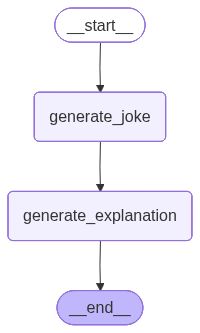

In [7]:
chat_workflow

In [8]:
initial_state = {
    "topic" : "GenAI Progress in India"
}

In [9]:
config_1 = { "configurable" : { "thread_id" : "1" } }

final_state = chat_workflow.invoke( initial_state, config = config_1 )

final_state

{'topic': 'GenAI Progress in India',
 'joke': 'GenAI progress in India is so fast that by the time you finish saying “build me an app,” the AI has shipped a full product, written a pitch deck, and ordered chai—without you lifting a finger.',
 'explanation': "Here's a clear explanation of the joke and why it’s funny:\n\nTL;DR\n- It’s a hyperbolic dig at how GenAI progress in India is portrayed as lightning-fast—so fast that, while you’re still saying “build me an app,” the AI has already shipped a full product, written a pitch deck, and even ordered chai, all without you lifting a finger.\n\nWhy it’s funny\n- Exaggerated speed: “By the time you finish saying” is a classic joke device to imply instantaneous results. It’s an over-the-top way to say AI can do everything almost instantly.\n- End-to-end work showcase: The list—ship a product, write a pitch deck, order chai—covers multiple heavy, real-world tasks. It’s humorous because AI doing all of that without human effort would be incred

In [10]:
chat_workflow.get_state(config_1)

StateSnapshot(values={'topic': 'GenAI Progress in India', 'joke': 'GenAI progress in India is so fast that by the time you finish saying “build me an app,” the AI has shipped a full product, written a pitch deck, and ordered chai—without you lifting a finger.', 'explanation': "Here's a clear explanation of the joke and why it’s funny:\n\nTL;DR\n- It’s a hyperbolic dig at how GenAI progress in India is portrayed as lightning-fast—so fast that, while you’re still saying “build me an app,” the AI has already shipped a full product, written a pitch deck, and even ordered chai, all without you lifting a finger.\n\nWhy it’s funny\n- Exaggerated speed: “By the time you finish saying” is a classic joke device to imply instantaneous results. It’s an over-the-top way to say AI can do everything almost instantly.\n- End-to-end work showcase: The list—ship a product, write a pitch deck, order chai—covers multiple heavy, real-world tasks. It’s humorous because AI doing all of that without human eff

In [11]:
from rich import print as rprint
import json

rprint(chat_workflow.get_state(config_1))

StateSnapshot(
    values={
        'topic': 'GenAI Progress in India',
        'joke': 'GenAI progress in India is so fast that by the time you finish saying “build me an app,” the AI 
has shipped a full product, written a pitch deck, and ordered chai—without you lifting a finger.',
        'explanation': "Here's a clear explanation of the joke and why it’s funny:\n\nTL;DR\n- It’s a hyperbolic 
dig at how GenAI progress in India is portrayed as lightning-fast—so fast that, while you’re still saying “build me
an app,” the AI has already shipped a full product, written a pitch deck, and even ordered chai, all without you 
lifting a finger.\n\nWhy it’s funny\n- Exaggerated speed: “By the time you finish saying” is a classic joke device 
to imply instantaneous results. It’s an over-the-top way to say AI can do everything almost instantly.\n- 
End-to-end work showcase: The list—ship a product, write a pitch deck, order chai—covers multiple heavy, real-world
tasks. It’s humorous because AI doing all of that without human effort would be incredibly impressive (and a bit 
absurd).\n- Cultural touchpoints: \n  - “Chai” (Indian tea) is a culturally specific detail that adds local flavor 
and familiarity for Indian audiences, while also signaling hospitality and a sense of everyday life.\n  - “Pitch 
deck” nods to startup culture: making business materials quickly is a relatable but aspirational goal in tech 
hubs.\n- “Without you lifting a finger”: Plays on automation and “hands-off” AI, poking fun at how GenAI is 
supposed to simplify work so you don’t have to do anything yourself.\n\nCultural/contextual notes\n- The joke leans
on India’s reputation for tech talent and a brisk, efficiency-minded work culture, while also acknowledging the 
ubiquity of chai as a social staple.\n- It’s a playful stereotype in service of a tech punchline, not a literal 
claim about every AI project or every Indian company.\n\nIf you’d like, I can tailor the explanation for a specific
audience (e.g., non-technical readers, executives, or a comic-writing context) or provide a couple of alternate 
punchlines with similar humor."
    },
    next=(),
    config={
        'configurable': {
            'thread_id': '1',
            'checkpoint_ns': '',
            'checkpoint_id': '1f0f50a1-b6f4-6ee9-8002-d96820065dfd'
        }
    },
    metadata={'source': 'loop', 'step': 2, 'parents': {}},
    created_at='2026-01-19T07:40:20.724285+00:00',
    parent_config={
        'configurable': {
            'thread_id': '1',
            'checkpoint_ns': '',
            'checkpoint_id': '1f0f50a1-3194-60d8-8001-e8758999a1f0'
        }
    },
    tasks=(),
    interrupts=()
)

In [12]:
state_history = list(chat_workflow.get_state_history(config_1))

rprint(state_history)

[
    StateSnapshot(
        values={
            'topic': 'GenAI Progress in India',
            'joke': 'GenAI progress in India is so fast that by the time you finish saying “build me an app,” the 
AI has shipped a full product, written a pitch deck, and ordered chai—without you lifting a finger.',
            'explanation': "Here's a clear explanation of the joke and why it’s funny:\n\nTL;DR\n- It’s a 
hyperbolic dig at how GenAI progress in India is portrayed as lightning-fast—so fast that, while you’re still 
saying “build me an app,” the AI has already shipped a full product, written a pitch deck, and even ordered chai, 
all without you lifting a finger.\n\nWhy it’s funny\n- Exaggerated speed: “By the time you finish saying” is a 
classic joke device to imply instantaneous results. It’s an over-the-top way to say AI can do everything almost 
instantly.\n- End-to-end work showcase: The list—ship a product, write a pitch deck, order chai—covers multiple 
heavy, real-world tasks. It’s humorous because AI doing all of that without human effort would be incredibly 
impressive (and a bit absurd).\n- Cultural touchpoints: \n  - “Chai” (Indian tea) is a culturally specific detail 
that adds local flavor and familiarity for Indian audiences, while also signaling hospitality and a sense of 
everyday life.\n  - “Pitch deck” nods to startup culture: making business materials quickly is a relatable but 
aspirational goal in tech hubs.\n- “Without you lifting a finger”: Plays on automation and “hands-off” AI, poking 
fun at how GenAI is supposed to simplify work so you don’t have to do anything yourself.\n\nCultural/contextual 
notes\n- The joke leans on India’s reputation for tech talent and a brisk, efficiency-minded work culture, while 
also acknowledging the ubiquity of chai as a social staple.\n- It’s a playful stereotype in service of a tech 
punchline, not a literal claim about every AI project or every Indian company.\n\nIf you’d like, I can tailor the 
explanation for a specific audience (e.g., non-technical readers, executives, or a comic-writing context) or 
provide a couple of alternate punchlines with similar humor."
        },
        next=(),
        config={
            'configurable': {
                'thread_id': '1',
                'checkpoint_ns': '',
                'checkpoint_id': '1f0f50a1-b6f4-6ee9-8002-d96820065dfd'
            }
        },
        metadata={'source': 'loop', 'step': 2, 'parents': {}},
        created_at='2026-01-19T07:40:20.724285+00:00',
        parent_config={
            'configurable': {
                'thread_id': '1',
                'checkpoint_ns': '',
                'checkpoint_id': '1f0f50a1-3194-60d8-8001-e8758999a1f0'
            }
        },
        tasks=(),
        interrupts=()
    ),
    StateSnapshot(
        values={
            'topic': 'GenAI Progress in India',
            'joke': 'GenAI progress in India is so fast that by the time you finish saying “build me an app,” the 
AI has shipped a full product, written a pitch deck, and ordered chai—without you lifting a finger.'
        },
        next=('generate_explanation',),
        config={
            'configurable': {
                'thread_id': '1',
                'checkpoint_ns': '',
                'checkpoint_id': '1f0f50a1-3194-60d8-8001-e8758999a1f0'
            }
        },
        metadata={'source': 'loop', 'step': 1, 'parents': {}},
        created_at='2026-01-19T07:40:06.738540+00:00',
        parent_config={
            'configurable': {
                'thread_id': '1',
                'checkpoint_ns': '',
                'checkpoint_id': '1f0f50a0-d75b-68a2-8000-8533974eaadd'
            }
        },
        tasks=(
            PregelTask(
                id='0d3d149f-3aea-e3b3-7fac-79893c205f3f',
                name='generate_explanation',
                path=('__pregel_pull', 'generate_explanation'),
                error=None,
                interrupts=(),
                state=None,
        

In [13]:
# Now testing with a different thread
initial_state_thread_2 = {
    "topic" : "Critical - GenAI Progress in India"
}

config_2 = { "configurable" : { "thread_id": "2" } }

final_state_thread_2 = chat_workflow.invoke(initial_state_thread_2, config = config_2)

In [14]:
final_state_thread_2

{'topic': 'Critical - GenAI Progress in India',
 'joke': 'GenAI progress in India is critical: it can spit out a groundbreaking insight in five minutes—after spending the next hour filling out forms to get permission to share it.',
 'explanation': "Here's a concise explanation of the joke and what it’s doing:\n\n- Core idea: The joke contrasts the speed of GenAI (can spit out a groundbreaking insight in five minutes) with the slowness of bureaucratic processes (spending an hour filling out forms to get permission to share it). The humor comes from the sharp mismatch between innovation and red tape.\n\n- What’s being satirized: It pokes fun at bureaucracy and permission culture—often perceived (rightly or wrongly) as slow and tedious—especially around data sharing, approvals, and intellectual property in professional or governmental contexts.\n\n- Comedy mechanics at work:\n  - Juxtaposition/contrast: Fast AI output vs. slow bureaucratic approval.\n  - Hyperbole: “five minutes” to gener

In [15]:
state_thread_2 = chat_workflow.get_state(config_2)

In [16]:
rprint(state_thread_2)

StateSnapshot(
    values={
        'topic': 'Critical - GenAI Progress in India',
        'joke': 'GenAI progress in India is critical: it can spit out a groundbreaking insight in five 
minutes—after spending the next hour filling out forms to get permission to share it.',
        'explanation': "Here's a concise explanation of the joke and what it’s doing:\n\n- Core idea: The joke 
contrasts the speed of GenAI (can spit out a groundbreaking insight in five minutes) with the slowness of 
bureaucratic processes (spending an hour filling out forms to get permission to share it). The humor comes from the
sharp mismatch between innovation and red tape.\n\n- What’s being satirized: It pokes fun at bureaucracy and 
permission culture—often perceived (rightly or wrongly) as slow and tedious—especially around data sharing, 
approvals, and intellectual property in professional or governmental contexts.\n\n- Comedy mechanics at work:\n  - 
Juxtaposition/contrast: Fast AI output vs. slow bureaucratic approval.\n  - Hyperbole: “five minutes” to generate a
groundbreaking insight signals extraordinary AI speed; “an hour filling out forms” exaggerates the red-tape 
burden.\n  - Irony: The obvious value of a quick insight is undercut by the absurdly onerous process required 
before sharing it.\n\n- Broader message: If AI progress is to be truly beneficial, governance, policy, and 
administrative processes need to keep pace with technology. Without streamlining permissions, even brilliant AI 
breakthroughs may not reach their audience or be put into practice.\n\n- Sensitivity: The joke uses a stereotype 
about bureaucratic inefficiency in India. It’s intended as satire of procedural bottlenecks rather than a blanket 
statement about an entire country or people. If you use it elsewhere, consider audience and context to avoid unfair
generalizations.\n\nIf you’d like, I can tailor this explanation for a slide, a paper, or a quick social-media 
caption."
    },
    next=(),
    config={
        'configurable': {
            'thread_id': '2',
            'checkpoint_ns': '',
            'checkpoint_id': '1f0f50a2-d4f6-672a-8002-34f6725e5c66'
        }
    },
    metadata={'source': 'loop', 'step': 2, 'parents': {}},
    created_at='2026-01-19T07:40:50.714179+00:00',
    parent_config={
        'configurable': {
            'thread_id': '2',
            'checkpoint_ns': '',
            'checkpoint_id': '1f0f50a2-4d75-6ae8-8001-ac6b258a0560'
        }
    },
    tasks=(),
    interrupts=()
)

In [17]:
state_history_thread_2 = list(chat_workflow.get_state_history(config_2))

In [18]:
rprint(state_history_thread_2)

[
    StateSnapshot(
        values={
            'topic': 'Critical - GenAI Progress in India',
            'joke': 'GenAI progress in India is critical: it can spit out a groundbreaking insight in five 
minutes—after spending the next hour filling out forms to get permission to share it.',
            'explanation': "Here's a concise explanation of the joke and what it’s doing:\n\n- Core idea: The joke 
contrasts the speed of GenAI (can spit out a groundbreaking insight in five minutes) with the slowness of 
bureaucratic processes (spending an hour filling out forms to get permission to share it). The humor comes from the
sharp mismatch between innovation and red tape.\n\n- What’s being satirized: It pokes fun at bureaucracy and 
permission culture—often perceived (rightly or wrongly) as slow and tedious—especially around data sharing, 
approvals, and intellectual property in professional or governmental contexts.\n\n- Comedy mechanics at work:\n  - 
Juxtaposition/contrast: Fast AI output vs. slow bureaucratic approval.\n  - Hyperbole: “five minutes” to generate a
groundbreaking insight signals extraordinary AI speed; “an hour filling out forms” exaggerates the red-tape 
burden.\n  - Irony: The obvious value of a quick insight is undercut by the absurdly onerous process required 
before sharing it.\n\n- Broader message: If AI progress is to be truly beneficial, governance, policy, and 
administrative processes need to keep pace with technology. Without streamlining permissions, even brilliant AI 
breakthroughs may not reach their audience or be put into practice.\n\n- Sensitivity: The joke uses a stereotype 
about bureaucratic inefficiency in India. It’s intended as satire of procedural bottlenecks rather than a blanket 
statement about an entire country or people. If you use it elsewhere, consider audience and context to avoid unfair
generalizations.\n\nIf you’d like, I can tailor this explanation for a slide, a paper, or a quick social-media 
caption."
        },
        next=(),
        config={
            'configurable': {
                'thread_id': '2',
                'checkpoint_ns': '',
                'checkpoint_id': '1f0f50a2-d4f6-672a-8002-34f6725e5c66'
            }
        },
        metadata={'source': 'loop', 'step': 2, 'parents': {}},
        created_at='2026-01-19T07:40:50.714179+00:00',
        parent_config={
            'configurable': {
                'thread_id': '2',
                'checkpoint_ns': '',
                'checkpoint_id': '1f0f50a2-4d75-6ae8-8001-ac6b258a0560'
            }
        },
        tasks=(),
        interrupts=()
    ),
    StateSnapshot(
        values={
            'topic': 'Critical - GenAI Progress in India',
            'joke': 'GenAI progress in India is critical: it can spit out a groundbreaking insight in five 
minutes—after spending the next hour filling out forms to get permission to share it.'
        },
        next=('generate_explanation',),
        config={
            'configurable': {
                'thread_id': '2',
                'checkpoint_ns': '',
                'checkpoint_id': '1f0f50a2-4d75-6ae8-8001-ac6b258a0560'
            }
        },
        metadata={'source': 'loop', 'step': 1, 'parents': {}},
        created_at='2026-01-19T07:40:36.505657+00:00',
        parent_config={
            'configurable': {
                'thread_id': '2',
                'checkpoint_ns': '',
                'checkpoint_id': '1f0f50a1-b76c-69a5-8000-b6ca74cabe01'
            }
        },
        tasks=(
            PregelTask(
                id='22318b1e-6acb-9c82-518b-aa4af9f83b46',
                name='generate_explanation',
                path=('__pregel_pull', 'generate_explanation'),
                error=None,
                interrupts=(),
                state=None,
                result={
                    'explanation': "Here's a concise explanation of the joke and what it’s doing:\n\n- Core idea: 
The joke contrasts the speed of GenAI (can spit 

## Time Travel

In [19]:
intermediate_state_via_checkpoint = chat_workflow.get_state( { "configurable" : { "thread_id" : "1", "checkpoint_id" : "1f0f4ff4-926d-6591-8000-f1e2ab80dd7b" }})

In [20]:
rprint(intermediate_state_via_checkpoint)

StateSnapshot(
    values={},
    next=(),
    config={'configurable': {'thread_id': '1', 'checkpoint_id': '1f0f4ff4-926d-6591-8000-f1e2ab80dd7b'}},
    metadata=None,
    created_at=None,
    parent_config=None,
    tasks=(),
    interrupts=()
)

In [21]:
new_state_in_thread_1_checkpoint_1 = chat_workflow.invoke( None, { "configurable" :  { "thread_id" : "1", "checkpoint" : "1f0f4ff4-926d-6591-8000-f1e2ab80dd7b" }})

In [22]:
rprint(new_state_in_thread_1_checkpoint_1)

{
    'topic': 'GenAI Progress in India',
    'joke': 'GenAI progress in India is so fast that by the time you finish saying “build me an app,” the AI has 
shipped a full product, written a pitch deck, and ordered chai—without you lifting a finger.',
    'explanation': "Here's a clear explanation of the joke and why it’s funny:\n\nTL;DR\n- It’s a hyperbolic dig at
how GenAI progress in India is portrayed as lightning-fast—so fast that, while you’re still saying “build me an 
app,” the AI has already shipped a full product, written a pitch deck, and even ordered chai, all without you 
lifting a finger.\n\nWhy it’s funny\n- Exaggerated speed: “By the time you finish saying” is a classic joke device 
to imply instantaneous results. It’s an over-the-top way to say AI can do everything almost instantly.\n- 
End-to-end work showcase: The list—ship a product, write a pitch deck, order chai—covers multiple heavy, real-world
tasks. It’s humorous because AI doing all of that without human effort would be incredibly impressive (and a bit 
absurd).\n- Cultural touchpoints: \n  - “Chai” (Indian tea) is a culturally specific detail that adds local flavor 
and familiarity for Indian audiences, while also signaling hospitality and a sense of everyday life.\n  - “Pitch 
deck” nods to startup culture: making business materials quickly is a relatable but aspirational goal in tech 
hubs.\n- “Without you lifting a finger”: Plays on automation and “hands-off” AI, poking fun at how GenAI is 
supposed to simplify work so you don’t have to do anything yourself.\n\nCultural/contextual notes\n- The joke leans
on India’s reputation for tech talent and a brisk, efficiency-minded work culture, while also acknowledging the 
ubiquity of chai as a social staple.\n- It’s a playful stereotype in service of a tech punchline, not a literal 
claim about every AI project or every Indian company.\n\nIf you’d like, I can tailor the explanation for a specific
audience (e.g., non-technical readers, executives, or a comic-writing context) or provide a couple of alternate 
punchlines with similar humor."
}

In [23]:
state_history_thread_1_now  = list(chat_workflow.get_state_history(config_2))
rprint(state_history_thread_1_now)

[
    StateSnapshot(
        values={
            'topic': 'Critical - GenAI Progress in India',
            'joke': 'GenAI progress in India is critical: it can spit out a groundbreaking insight in five 
minutes—after spending the next hour filling out forms to get permission to share it.',
            'explanation': "Here's a concise explanation of the joke and what it’s doing:\n\n- Core idea: The joke 
contrasts the speed of GenAI (can spit out a groundbreaking insight in five minutes) with the slowness of 
bureaucratic processes (spending an hour filling out forms to get permission to share it). The humor comes from the
sharp mismatch between innovation and red tape.\n\n- What’s being satirized: It pokes fun at bureaucracy and 
permission culture—often perceived (rightly or wrongly) as slow and tedious—especially around data sharing, 
approvals, and intellectual property in professional or governmental contexts.\n\n- Comedy mechanics at work:\n  - 
Juxtaposition/contrast: Fast AI output vs. slow bureaucratic approval.\n  - Hyperbole: “five minutes” to generate a
groundbreaking insight signals extraordinary AI speed; “an hour filling out forms” exaggerates the red-tape 
burden.\n  - Irony: The obvious value of a quick insight is undercut by the absurdly onerous process required 
before sharing it.\n\n- Broader message: If AI progress is to be truly beneficial, governance, policy, and 
administrative processes need to keep pace with technology. Without streamlining permissions, even brilliant AI 
breakthroughs may not reach their audience or be put into practice.\n\n- Sensitivity: The joke uses a stereotype 
about bureaucratic inefficiency in India. It’s intended as satire of procedural bottlenecks rather than a blanket 
statement about an entire country or people. If you use it elsewhere, consider audience and context to avoid unfair
generalizations.\n\nIf you’d like, I can tailor this explanation for a slide, a paper, or a quick social-media 
caption."
        },
        next=(),
        config={
            'configurable': {
                'thread_id': '2',
                'checkpoint_ns': '',
                'checkpoint_id': '1f0f50a2-d4f6-672a-8002-34f6725e5c66'
            }
        },
        metadata={'source': 'loop', 'step': 2, 'parents': {}},
        created_at='2026-01-19T07:40:50.714179+00:00',
        parent_config={
            'configurable': {
                'thread_id': '2',
                'checkpoint_ns': '',
                'checkpoint_id': '1f0f50a2-4d75-6ae8-8001-ac6b258a0560'
            }
        },
        tasks=(),
        interrupts=()
    ),
    StateSnapshot(
        values={
            'topic': 'Critical - GenAI Progress in India',
            'joke': 'GenAI progress in India is critical: it can spit out a groundbreaking insight in five 
minutes—after spending the next hour filling out forms to get permission to share it.'
        },
        next=('generate_explanation',),
        config={
            'configurable': {
                'thread_id': '2',
                'checkpoint_ns': '',
                'checkpoint_id': '1f0f50a2-4d75-6ae8-8001-ac6b258a0560'
            }
        },
        metadata={'source': 'loop', 'step': 1, 'parents': {}},
        created_at='2026-01-19T07:40:36.505657+00:00',
        parent_config={
            'configurable': {
                'thread_id': '2',
                'checkpoint_ns': '',
                'checkpoint_id': '1f0f50a1-b76c-69a5-8000-b6ca74cabe01'
            }
        },
        tasks=(
            PregelTask(
                id='22318b1e-6acb-9c82-518b-aa4af9f83b46',
                name='generate_explanation',
                path=('__pregel_pull', 'generate_explanation'),
                error=None,
                interrupts=(),
                state=None,
                result={
                    'explanation': "Here's a concise explanation of the joke and what it’s doing:\n\n- Core idea: 
The joke contrasts the speed of GenAI (can spit 

### Updating the State

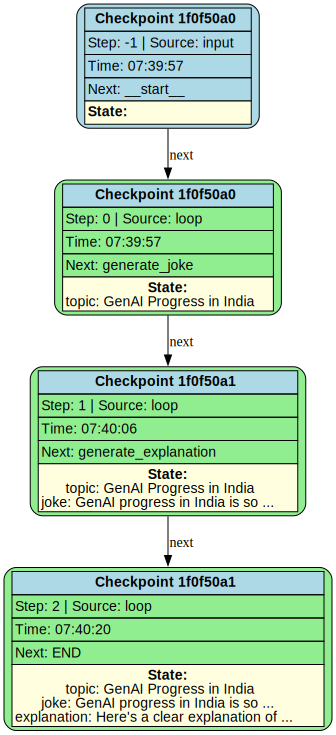

In [24]:
from checkpoint_visualizer import visualize_checkpoints, visualize_checkpoints_compact
visualize_checkpoints(chat_workflow, thread_id="1")

In [25]:
new_state = chat_workflow.update_state( { 
    "configurable" : {
        "thread_id" : "1",
        "checkpoint_id" : "1f0f4fe2-5bb1-6c4a-bfff-5929feb75a5b",
        "checkpoint_ns" : "" 
        } },
    {
    "topic" : "SarvamAI Contribution in India"
    })

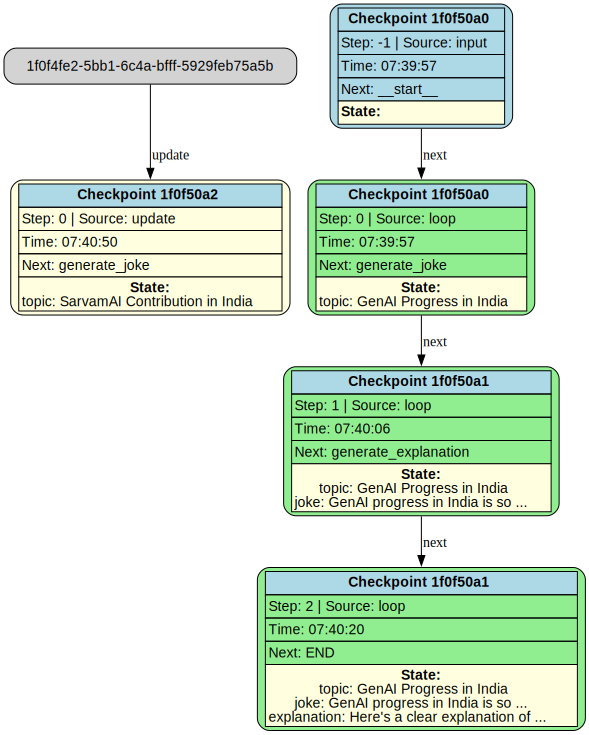

In [26]:
visualize_checkpoints(chat_workflow, thread_id="1")

In [27]:
new_state_history = list(chat_workflow.get_state_history(config_1))

In [28]:
rprint(new_state_history)

[
    StateSnapshot(
        values={'topic': 'SarvamAI Contribution in India'},
        next=('generate_joke',),
        config={
            'configurable': {
                'thread_id': '1',
                'checkpoint_ns': '',
                'checkpoint_id': '1f0f50a2-d63f-6daa-8000-f9ef02c9661d'
            }
        },
        metadata={'source': 'update', 'step': 0, 'parents': {}},
        created_at='2026-01-19T07:40:50.849109+00:00',
        parent_config={
            'configurable': {
                'thread_id': '1',
                'checkpoint_ns': '',
                'checkpoint_id': '1f0f4fe2-5bb1-6c4a-bfff-5929feb75a5b'
            }
        },
        tasks=(
            PregelTask(
                id='7c7c3575-3a5a-9fdf-4f5c-b1d54956660a',
                name='generate_joke',
                path=('__pregel_pull', 'generate_joke'),
                error=None,
                interrupts=(),
                state=None,
                result=None
            ),
        ),
        interrupts=()
    ),
    StateSnapshot(
        values={
            'topic': 'GenAI Progress in India',
            'joke': 'GenAI progress in India is so fast that by the time you finish saying “build me an app,” the 
AI has shipped a full product, written a pitch deck, and ordered chai—without you lifting a finger.',
            'explanation': "Here's a clear explanation of the joke and why it’s funny:\n\nTL;DR\n- It’s a 
hyperbolic dig at how GenAI progress in India is portrayed as lightning-fast—so fast that, while you’re still 
saying “build me an app,” the AI has already shipped a full product, written a pitch deck, and even ordered chai, 
all without you lifting a finger.\n\nWhy it’s funny\n- Exaggerated speed: “By the time you finish saying” is a 
classic joke device to imply instantaneous results. It’s an over-the-top way to say AI can do everything almost 
instantly.\n- End-to-end work showcase: The list—ship a product, write a pitch deck, order chai—covers multiple 
heavy, real-world tasks. It’s humorous because AI doing all of that without human effort would be incredibly 
impressive (and a bit absurd).\n- Cultural touchpoints: \n  - “Chai” (Indian tea) is a culturally specific detail 
that adds local flavor and familiarity for Indian audiences, while also signaling hospitality and a sense of 
everyday life.\n  - “Pitch deck” nods to startup culture: making business materials quickly is a relatable but 
aspirational goal in tech hubs.\n- “Without you lifting a finger”: Plays on automation and “hands-off” AI, poking 
fun at how GenAI is supposed to simplify work so you don’t have to do anything yourself.\n\nCultural/contextual 
notes\n- The joke leans on India’s reputation for tech talent and a brisk, efficiency-minded work culture, while 
also acknowledging the ubiquity of chai as a social staple.\n- It’s a playful stereotype in service of a tech 
punchline, not a literal claim about every AI project or every Indian company.\n\nIf you’d like, I can tailor the 
explanation for a specific audience (e.g., non-technical readers, executives, or a comic-writing context) or 
provide a couple of alternate punchlines with similar humor."
        },
        next=(),
        config={
            'configurable': {
                'thread_id': '1',
                'checkpoint_ns': '',
                'checkpoint_id': '1f0f50a1-b6f4-6ee9-8002-d96820065dfd'
            }
        },
        metadata={'source': 'loop', 'step': 2, 'parents': {}},
        created_at='2026-01-19T07:40:20.724285+00:00',
        parent_config={
            'configurable': {
                'thread_id': '1',
                'checkpoint_ns': '',
                'checkpoint_id': '1f0f50a1-3194-60d8-8001-e8758999a1f0'
            }
        },
        tasks=(),
        interrupts=()
    ),
    StateSnapshot(
        values={
            'topic': 'GenAI Progress in India',
            'joke': 'GenAI progress in India is so fast that by the time you finish saying “

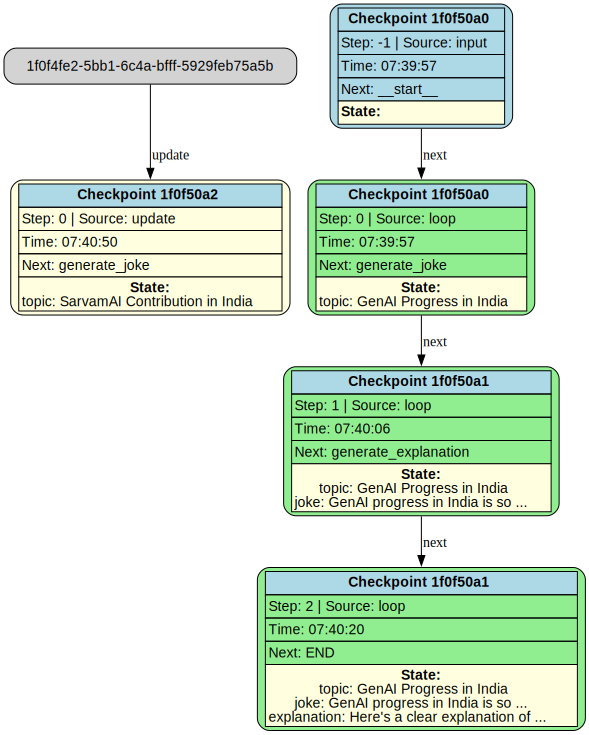

In [29]:
visualize_checkpoints(chat_workflow, thread_id="1")

In [30]:
new_state = chat_workflow.invoke(None,  { "configurable" : { "thread_id" : "1", "checkpoint_id" : "1f0f5088-6a2c-6272-8000-bb08f191f432"}})

EmptyInputError: Received no input for __start__

In [ ]:
rprint(new_state)

In [ ]:
from checkpoint_visualizer import visualize_checkpoints, visualize_checkpoints_compact
visualize_checkpoints(chat_workflow, thread_id="1")